# Basic GIS Tools with Rasterio

Albin Wells -- Last updated June 2023

This notebook provides a framework and sample of ways to execute some basic GIS geoprocessing steps in python using the rasterio module. This notebook goes through examples on how to:
- plot shapefiles and geotiff files
- convert netCDF data to geotiff
- clip geotiff files with a shapefile or another geotiff
- reproject shapefiles
- resample and reproject geotiff files
- fill holes in geotiff data
- mosaic two geotiffs

### Import necessary modules

In [1]:
# Creating a python module: https://towardsdatascience.com/make-your-own-python-package-6d08a400fc2d
# https://python-packaging-tutorial.readthedocs.io/en/latest/setup_py.html

In [2]:
# rasterio, xarray, rioxarray, matplotlib, matplotlib_scalebar, numpy, fiona, geopandas, pandas, and (maybe?) pyproj
import rasterio
import rasterio.plot
from rasterio.plot import show
from rasterio.warp import Resampling

import rioxarray
import xarray

import glob, os, warnings
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import fiona
import shapely.geometry
import geopandas as gpd

Import [raster basics](https://github.com/albinwwells/Raster-Basics)

In [3]:
import raster_basics
from raster_basics.RasterBasics import show_fig, rasterLike
from raster_basics.RasterBasics import shpReprojection, shpBuffer, shpClip, tifReprojectionResample, mosaic_files
from raster_basics.RasterBasics import fillHole, extract_along_line,points_along_lines, end_points
# from raster_basics.DataPlots import plotMany
from raster_basics.GlacierFunctions import glacierSlope
# from raster_basics.BaseFunctions import FUNCTION

### Identify data files and plot data

- Glacier outline inventory was downloaded from the [GLIMS Glacier Database](https://www.glims.org/RGI/rgi60_dl.html)
- The RGI Region 1 ice thickness data from Millan et al. 2022 was accessed from [this online portal](https://doi.org/10.6096/1007)
- The netCDF thickness for Gulkana was taken from Farinotti et al. 2019, accessed from [this portal](https://doi.org/10.3929/ethz-b-000315707), and converted into a netCDF file separately for experimental purposes
- The elevation change rate data to show mosaicking was published in Hugonnet et al. 2021 and acessed from [this portal](https://doi.org/10.6096/13)


In [4]:
regional_thickness = 'Millan_Thickness_RGI1.tif' # rgi region 1 ice thickness data (Millan et al. 2022)
rgi_glaciers = '01_rgi60_Alaska.shp' # region 1 randolph glacier inventory dataset (RGI Consortium)

# let's use regional thickness and regional shapefile

In [5]:
rgi_glaciers = '/Users/albinwells/Desktop/GlacierMB/Other/01_rgi60_Alaska-2.shp'

We can make plots pretty easily with matplotlib. 
In this case, I've added a [scalebar](https://pypi.org/project/matplotlib-scalebar/) which is based on the image extent (this is only the case when dx is set to 1).
We can also give it any color scheme which is based on [Matplotlib colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

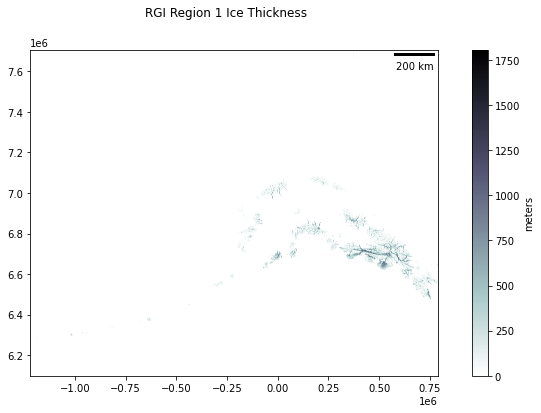

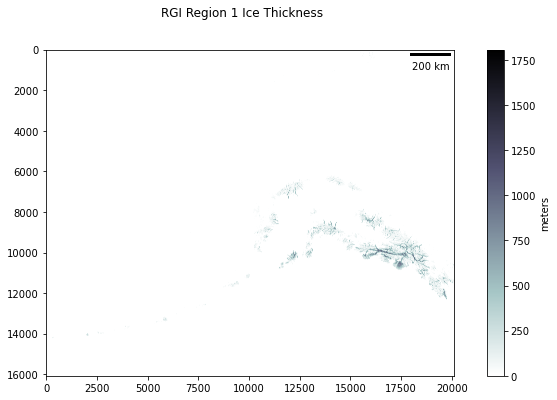

In [6]:
im = rasterio.open(regional_thickness).read(1)
rast_bounds = rasterio.open(regional_thickness).bounds # left, bottom, right, top
fig_bounds = [rast_bounds[0], rast_bounds[2], rast_bounds[1], rast_bounds[3]] # left, right, bottom, top
title = 'RGI Region 1 Ice Thickness'
color = 'bone_r'
ctitle = 'meters'
show_fig(im, title, color, ctitle, bounds=fig_bounds, res=1)

# identical to the last figure, but we have axis as array coordinates not map coordinates. Scalebar still works
show_fig(im, title, color, ctitle, res=rasterio.open(regional_thickness).res[0])

Now, we can also very quickly look at a geoTIFF by calling the built-in rasterio.plot show function:

<AxesSubplot:title={'center':'RGI Region 1 Ice Thickness'}>

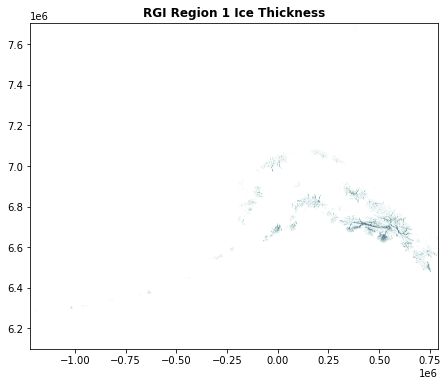

In [7]:
rast = rasterio.open(regional_thickness)

fig, ax = plt.subplots(figsize=(12,6))
show((rast, 1), ax=ax, cmap=color, title=title)

If we have input data as a netCDF file instead of a geotiff, one solution is to convert it to a geotiff and then follow the same steps. Note that we need to extract the desired variable (in this instance "uvelsurf", "vvelsurf", and "velsurf_mag")

<xarray.Dataset>
Dimensions:      (time: 2, y: 266, x: 356)
Coordinates:
  * time         (time) float32 0.0 1.0
  * y            (y) float32 9.175e+06 9.175e+06 ... 9.162e+06 9.162e+06
  * x            (x) float32 -1.62e+07 -1.62e+07 ... -1.618e+07 -1.618e+07
Data variables:
    topg         (time, y, x) float32 ...
    usurf        (time, y, x) float32 ...
    thk          (time, y, x) float32 ...
    smb          (time, y, x) float32 ...
    velbar_mag   (time, y, x) float32 ...
    velsurf_mag  (time, y, x) float32 ...
    uvelbase     (time, y, x) float32 ...
    vvelbase     (time, y, x) float32 ...
    uvelsurf     (time, y, x) float32 ...
    vvelsurf     (time, y, x) float32 ...
    divflux      (time, y, x) float32 ...


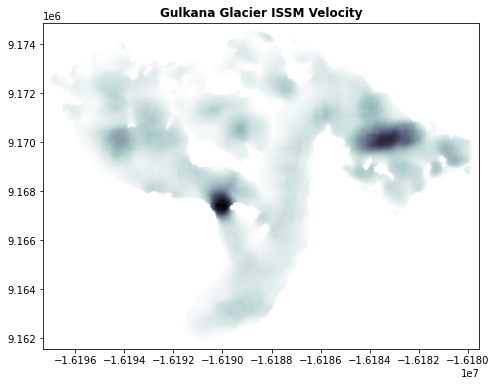

In [8]:
netcdf_file = 'ISSM_millan_model_output.nc'
xds = xarray.open_dataset(netcdf_file, decode_coords='all')
print(xds)
xds['velsurf_mag'].rio.to_raster('test_v.tif')

fig, ax = plt.subplots(figsize=(12,6))
show((rasterio.open('test_v.tif'), 1), ax=ax, cmap=color, title='Gulkana Glacier ISSM Velocity')

os.remove('test_v.tif')

### Extract our glacier outline

First, we have the RGI region 1 dataset. Here are some [mapping tips](https://geopandas.org/en/stable/docs/user_guide/mapping.html)

<AxesSubplot:>

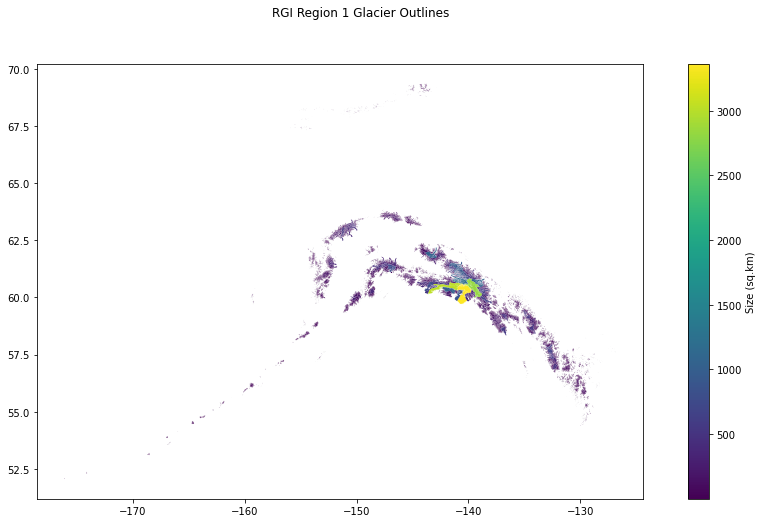

In [9]:
glaciers = gpd.read_file(rgi_glaciers)
# print(glaciers.head()) # to show the first 5 rows of the shapefile data
fig, ax = plt.subplots(figsize=(16,8))
fig.suptitle('RGI Region 1 Glacier Outlines')
glaciers.plot(column='Area', ax=ax, legend=True, legend_kwds={'label': 'Size (sq.km)', 'orientation': 'vertical'})


The "big pancake" [Malaspina glacier](https://en.wikipedia.org/wiki/Malaspina_Glacier) really sticks out even in a map of the entire region!
This is what it looks like from up-close (ish):

![Malaspina](https://upload.wikimedia.org/wikipedia/commons/thumb/5/57/Malaspina_Glacier%2C_Alaska_%2822800052331%29.jpg/1280px-Malaspina_Glacier%2C_Alaska_%2822800052331%29.jpg)

Now, let's focus on Gulkana and extract the shapefile feature:

<AxesSubplot:>

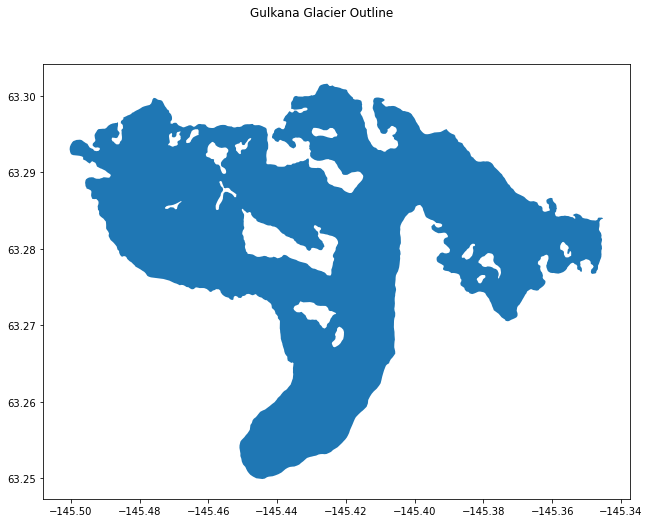

In [10]:
gulkana = glaciers[glaciers['Name']=='Gulkana Glacier']
# print(gulkana)
fig, ax = plt.subplots(figsize=(16,8))
fig.suptitle('Gulkana Glacier Outline')
gulkana.plot(ax=ax)

Let's save this as our new outline

In [11]:
gulkana_file = 'gulkana.shp'
gulkana.to_file(gulkana_file)

### Reproject files into the same coordinate system

**First, let's define a target coordinate system that we want to work in and a target resolution**

In [12]:
crs = 'EPSG:32606'  # UTM zone 6N
res = 20 # output pixel resolution (m)

**Now, let's reproject the shapefile**

In [13]:
reprojected_shp = 'gulkana_utm.shp'
shpReprojection(gulkana_file, crs, reprojected_shp)

We can plot and see that we're not seeing UTM Easting/Northing coordinates instead of the WGS84 Lat/Lon coordinates

<AxesSubplot:>

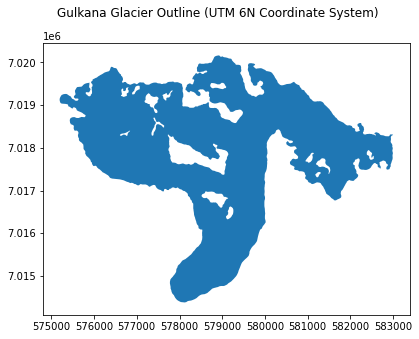

In [14]:
gulkana_utm = gpd.read_file(reprojected_shp)
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Gulkana Glacier Outline (UTM 6N Coordinate System)')
gulkana_utm.plot(ax=ax)

### Before we resample and reproject, let's clip the extent so we don't waste time doing this for the entire region 

In [15]:
gulkana_clipped = 'gulkana_thickness.tif' # output filename
shpClip(regional_thickness, reprojected_shp, gulkana_clipped, pad_size=10)
print('Initial coordinate system:', rasterio.open(gulkana_clipped).crs)

Initial coordinate system: EPSG:32607


Let's plot to see out result:

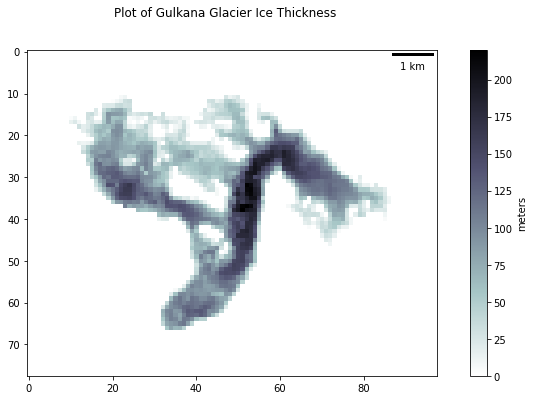

In [16]:
im = rasterio.open(gulkana_clipped)
title = 'Plot of Gulkana Glacier Ice Thickness'
color = 'bone_r'
ctitle = 'meters'
show_fig(im.read(1), title, color, ctitle, res=im.res[0])

If we wanted to clip a geotiff using another geotiff, we use the [rasterio.windows from_bounds function](https://rasterio.readthedocs.io/en/latest/api/rasterio.windows.html#rasterio.windows.from_bounds) as follows:

**Then, let's reproject the geotiff raster file**

In [17]:
gulkana_reprojected = 'gulkana_thickness_utm.tif' # output filename
tifReprojectionResample(gulkana_clipped, gulkana_reprojected, crs, res, Resampling.cubic_spline)
print('New coordinate system:', rasterio.open(gulkana_reprojected).crs)
print('New resolution:', rasterio.open(gulkana_reprojected).res, 'meters')

New coordinate system: EPSG:32606
New resolution: (20.0, 20.0) meters


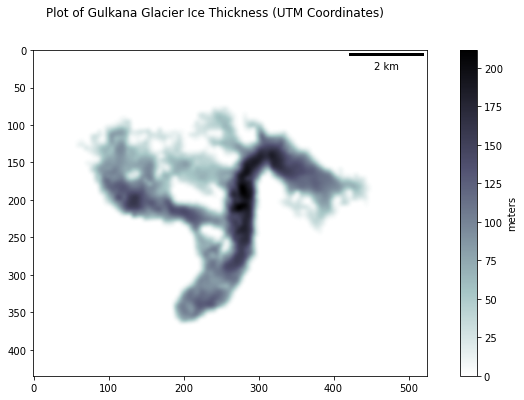

In [18]:
im = rasterio.open(gulkana_reprojected)
title = 'Plot of Gulkana Glacier Ice Thickness (UTM Coordinates)'
show_fig(im.read(1), title, color='bone_r', ctitle='meters', res=im.res[0])

### Sidenote: SIA for Gulkana to resolve velocity

In [19]:
# get DEM Gulkana
dem_file = '/Users/albinwells/Desktop/GlacierMB/Other/RGI1_DEM/RGI60-01.00570_dem.tif'
dem_reproj = 'gulkana_dem_reproj.tif'
tifReprojectionResample(dem_file, dem_reproj, crs, res, Resampling.cubic_spline, extent_file=gulkana_reprojected)


In [20]:
h = rasterio.open(gulkana_reprojected).read(1)
dem = rasterio.open(dem_reproj).read(1)

rr_slope = glacierSlope(dem, res) # rise/run slope
angle_slope = np.arctan(rr_slope)

A = 2.4e-24
rho = 850
g = 9.8

In [21]:
# for surface velocity 
v_surf_ms = 0.4*A*(h**4)*(rho*g*np.sin(angle_slope))**3
v_surf = v_surf_ms*31536000 # convert from m/s to m/yr

print('Maximum velocity is', round(np.max(v_surf), 0), 'm/yr')

Maximum velocity is 350.0 m/yr


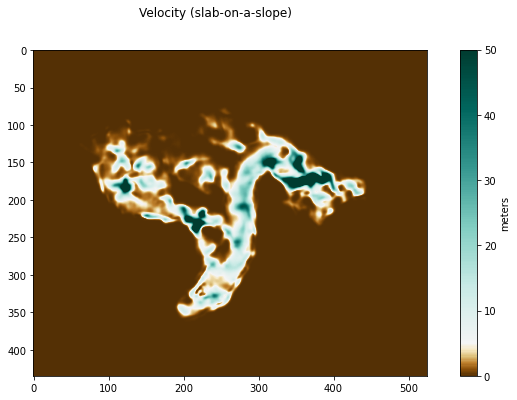

In [22]:
show_fig(v_surf, 'Velocity (slab-on-a-slope)', 'BrBG', 'meters', vmin=0, vcenter=5, vmax=50)

### Filling Missing Data

This is an example of how to quickly fill a hole in data. First, let's simulate data gaps. Then, we'll see how to fix it

In [23]:
with rasterio.open(gulkana_reprojected) as src:
    image = src.read(1)
    image[150] = np.nan
    image[200,280] = np.nan
    kwargs = src.meta.copy()
    destination = 'gulkana_with_datagaps.tif'
    with rasterio.open(destination, 'w', **kwargs) as dst:
        dst.write_band(1, image)

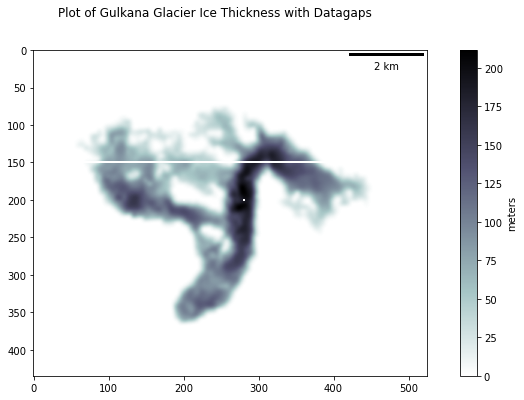

In [24]:
im = rasterio.open('gulkana_with_datagaps.tif')
title = 'Plot of Gulkana Glacier Ice Thickness with Datagaps'
show_fig(im.read(1), title, color='bone_r', ctitle='meters', res=im.res[0])

Let's see if this worked and filled the data with a reasonable value!

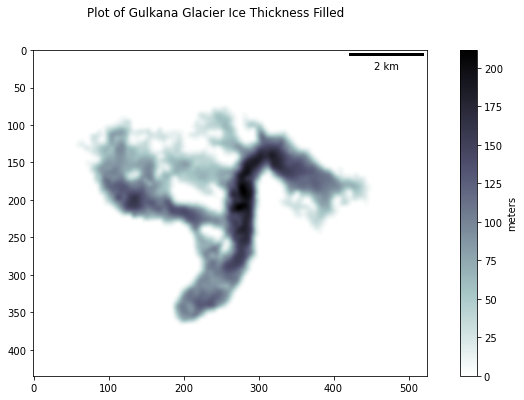

In [25]:
fillHole('gulkana_with_datagaps.tif', dest='gulkana_filled.tif')

im = rasterio.open('gulkana_filled.tif')
title = 'Plot of Gulkana Glacier Ice Thickness Filled'
show_fig(im.read(1), title, color='bone_r', ctitle='meters', res=im.res[0])

Filling worked pretty effectively, but it isn't identical to the original:

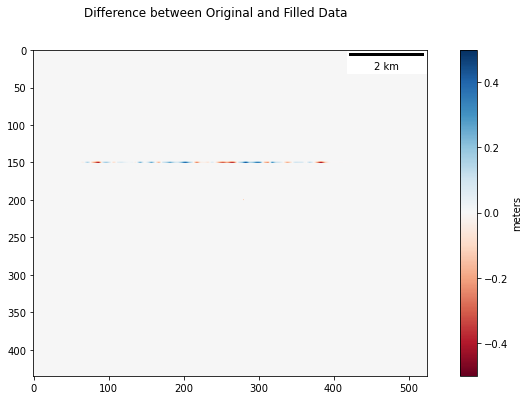

In [26]:
original = rasterio.open(gulkana_reprojected)
filled = rasterio.open('gulkana_filled.tif')
difference = np.subtract(original.read(1), filled.read(1))
title = 'Difference between Original and Filled Data'
show_fig(difference, title, color='RdBu', ctitle='meters', res=filled.res[0], vmin=-0.5, vcenter=0, vmax=0.5)

### Mosaicking

Sometimes, data might be split into multiple gridded sections. We can mosaic these grids into a larger area if we want to do some analysis that spans grid cells. We use 4 1x1 degree grid cells from Hugonnet et al. 2021 for elevation change rate in Alaska.

In [27]:
tile1 = 'N60W140_2000-2020_dhdt.tif'
tile2 = 'N60W141_2000-2020_dhdt.tif'
tile3 = 'N59W140_2000-2020_dhdt.tif'
tile4 = 'N59W141_2000-2020_dhdt.tif'
dhdt_files = [tile1, tile2, tile3, tile4]

Check that coordinate systems are consistent

In [28]:
for file in dhdt_files:
    print(file, 'has coordinate system:', rasterio.open(file).crs)

N60W140_2000-2020_dhdt.tif has coordinate system: EPSG:32607
N60W141_2000-2020_dhdt.tif has coordinate system: EPSG:32607
N59W140_2000-2020_dhdt.tif has coordinate system: EPSG:32607
N59W141_2000-2020_dhdt.tif has coordinate system: EPSG:32607


In [29]:
mosaic_output = 'dhdt_mosaic.tif'
mosaic_files(dhdt_files, mosaic_output)

**Finally, let's plot the result**

Let's obtain the proper shapefile shape and reproject it into the coordinate system...

In [30]:
malaspina = glaciers[glaciers['Name']=='Seward Glacier']
# print(malaspina)
malaspina_file = 'malaspina.shp'
malaspina.to_file(malaspina_file)
shpReprojection(malaspina_file, rasterio.open(tile1).crs, 'malaspina_utm.shp')

...and then plot it on top of our mosaic!

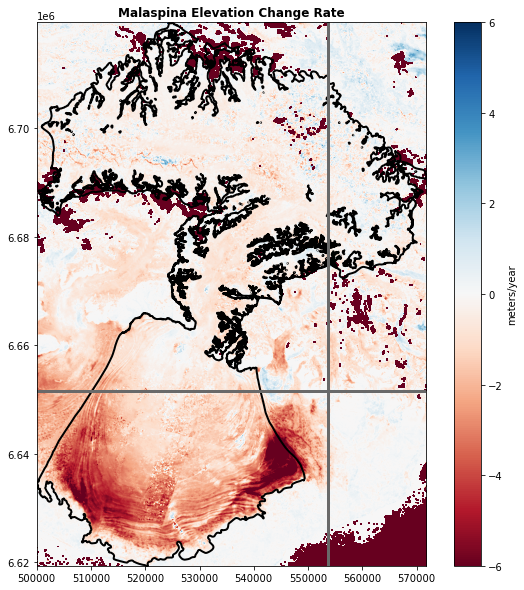

In [31]:
mosaic_array = rasterio.open(mosaic_output).read(1)

fig, ax = plt.subplots(figsize=(10,10))
c = ax.imshow(mosaic_array, cmap='RdBu', vmin=-6, vmax=6) # plot mosaic
show((rasterio.open(mosaic_output), 1), ax=ax, cmap='RdBu', 
     title='Malaspina Elevation Change Rate', vmin=-6, vmax=6)
fig.colorbar(c, label='meters/year', ax=ax)

malaspina_utm = gpd.read_file('malaspina_utm.shp') # plot shapefile
malaspina_utm.plot(ax=ax, facecolor='#FF000000', edgecolor='k', lw=2)

bounds = fiona.open('malaspina_utm.shp').bounds # crop plot my shapefile bounds
plt.xlim(bounds[0], bounds[2])
plt.ylim(bounds[1], bounds[3])
plt.axvline(x = rasterio.open(tile1).bounds[0], color = 'dimgray', lw=3) # show where our initial grids were
plt.axhline(y = rasterio.open(tile1).bounds[1], color = 'dimgray', lw=3)
plt.show()


## Miscellaneous

### Add buffer around a shapefile

In [32]:
shpBuffer(gulkana_file, dist=100, dst='gulkana_buffered.shp') # this one will return an error

/opt/anaconda3/envs/pyGlacierMassBalance/lib/python3.9/site-packages/raster_basics/RasterBasics.py:91: UserWarning: The shapefile is in a geographic coordinate system. Reproject the shapefile and try again
  warnings.warn("The shapefile is in a geographic coordinate system. Reproject the shapefile and try again")


In [33]:
shpBuffer(reprojected_shp, dist=100, dst='gulkana_buffered.shp')
gulkana_buffered = gpd.read_file('gulkana_buffered.shp')

<AxesSubplot:>

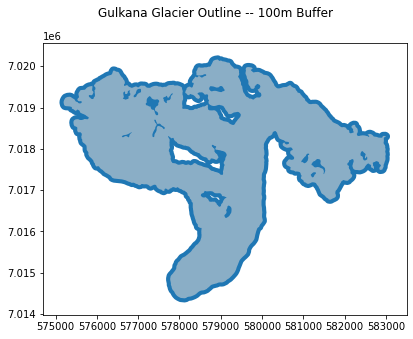

In [34]:
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Gulkana Glacier Outline -- 100m Buffer')
gulkana_buffered.plot(ax=ax)
gulkana_utm.plot(ax=ax, color='lightgrey', alpha=0.6)

### How to sample a raster along a line and make a graph

In [35]:
tiff_name = 'dhdt_mosaic.tif'
main_title = 'Malaspina dhdt'
cbar_title = 'Change in Elevation (m/yr)'
color = 'RdBu'
v_min = -6
v_max = 6

Build a simple GUI to determine where we want to sample our data

In [36]:
def sample_on_line(geotiff, vmin, vmax, cmap, c_label, title):
    # a gui to create a transect
    global stored_xvals, stored_yvals, asci, asci_list
    %matplotlib tk
    asci = 64
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(16, 10)

    # print and store selected values
    stored_xvals = []
    stored_yvals = []
    asci_list = []
    def onclick(event): # mouse click event
        global stored_xvals, stored_yvals, asci, asci_list
        asci = asci+1
        asci_list.append(asci)
        ix, iy = event.xdata, event.ydata
        stored_xvals.append(ix)
        stored_yvals.append(iy) 

        plt.autoscale(False)
        plt.plot(stored_xvals, stored_yvals, color='r', zorder=10) 
        plt.plot(ix, iy, color='r', marker='.', markersize=8, zorder=10)
        ax.annotate(chr(asci), (ix+10, iy+10), color='r', fontsize=16, zorder=20)
        plt.show()
        plt.savefig('Sampling along a line.jpg', dpi=300)

    cid = fig.canvas.mpl_connect('button_press_event', onclick) # initiate the butten click event

    tiff = rasterio.open(geotiff)
    rast_bounds = tiff.bounds # left, bottom, right, top
    c = ax.imshow(tiff.read(1), cmap=cmap, vmin=vmin, vmax=vmax) # plot mosaic
    plt.imshow(tiff.read(1), cmap=cmap, vmin=vmin, vmax=vmax, 
               extent=[rast_bounds[0], rast_bounds[2], rast_bounds[1], rast_bounds[3]])
    fig.colorbar(c, label=c_label, ax=ax)

    plt.xlabel('UTM Easting (m)', fontsize=12)
    plt.ylabel('UTM Northing (m)', fontsize=12)
    plt.title(title, fontsize=24, c='k')
    plt.grid()
    plt.tight_layout()
    plt.show()


In [37]:
# obtain the sampling transect using the GUI
sample_on_line(geotiff=tiff_name, vmin=v_min, vmax=v_max, cmap=color, c_label=cbar_title, title=main_title)


Now, let's sample along the line we just drew and plot the result

In [38]:
# extract raster values along the line
line_points = list(zip(stored_xvals, stored_yvals))
line = shapely.geometry.MultiLineString([[[p[0],p[1]] for p in line_points]])
xarr = rioxarray.open_rasterio(tiff_name).squeeze()
profile, coordinate = extract_along_line(xarr, line)
points = end_points(xarr, line_points)


In [39]:
# get the raster values along the line and the distances along the transect
vals = [float(x) for x in profile]
line_dists = [[coordinate[i], coordinate[i+1]] for i in range(len(coordinate)-1)]
dist = [math.dist(pair[0], pair[1]) for pair in line_dists]
dist = [sum(dist[:i]) for i in range(len(dist)+1)]

p_vals = [float(x) for x in points]
line_point_dists = [[line_points[i], line_points[i+1]] for i in range(len(line_points)-1)]
p_dist = [math.dist(pair[0], pair[1]) for pair in line_point_dists]
p_dist = [sum(p_dist[:i]) for i in range(len(p_dist)+1)]

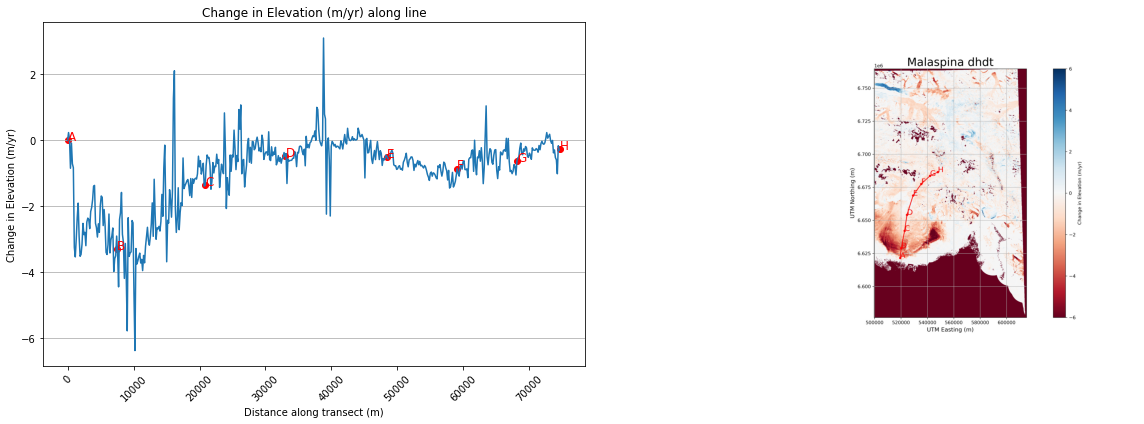

In [40]:
# plot the results
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(dist, vals)
ax1.scatter(p_dist, p_vals, color='r')
for i in range(len(asci_list)):
    ax1.annotate(chr(asci_list[i]), (p_dist[i]+20, p_vals[i]), color='r', fontsize=12)
ax1.grid(axis='y')
ax1.set_xlabel('Distance along transect (m)')
ax1.set_ylabel(cbar_title)
ax1.set_title(cbar_title + ' along line', c='k')
plt.setp(ax1.get_xticklabels(), rotation=45);

pic = plt.imread('Sampling along a line.jpg')
ax2.imshow(pic)
ax2.axis('off')
plt.tight_layout()


### How to get raster values along OGGM flowline

In this case, let's plot thickness along a flowline

In [41]:
tiff_name = 'gulkana_thickness_utm.tif'
# shapefile_name = 'gulkana-flowline.shp'
shapefile_name = 'RGI01_flowlines/RGI01_flowlines_utm.shp'
main_title = 'Gulkana Thickness'
cbar_title = 'Thickness (m)'
color = 'bone_r'
v_min = 0
v_max = 250

Let's look at our flowline for Gulkana

<AxesSubplot:>

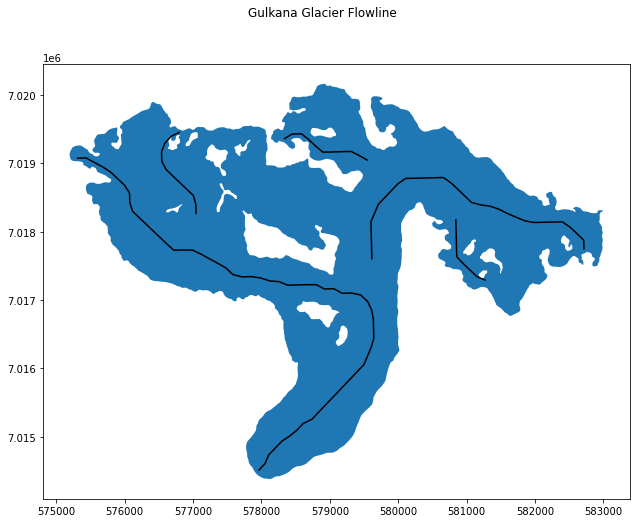

In [42]:
flowline = gpd.read_file(shapefile_name)
flowline = flowline[flowline['RGIID']=='RGI60-01.00570'] # get Gulkana flowline if we use regional OGGM flowlines
# print(glaciers.head()) # to show the first 5 rows of the shapefile data
fig, ax = plt.subplots(figsize=(16,8))
fig.suptitle('Gulkana Glacier Flowline')

gulkana_utm.plot(ax=ax)
flowline.plot(ax=ax, color='k')
# show((rasterio.open(tiff_name), 1), ax=ax, cmap='Blues')


...and only use the flowline for the main trunk, to keep things simpler

<AxesSubplot:>

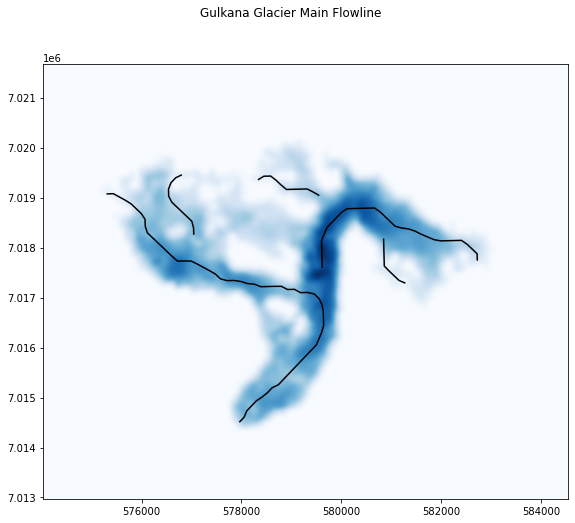

In [43]:
# main_flowline = flowline[flowline['name']=='flowline_main'] # if we're using my created flowline
main_flowline = flowline[flowline['SEGMENT_ID'] >= 0] # if we're using OGGM flowline
fig, ax = plt.subplots(figsize=(16,8))
fig.suptitle('Gulkana Glacier Main Flowline')
# gulkana_utm.plot(ax=ax)
main_flowline.plot(ax=ax, color='k')
show((rasterio.open(tiff_name), 1), ax=ax, cmap='Blues')


Now, let's sample along the line and plot the result

In [44]:
# extract raster values along the line
xarr = rioxarray.open_rasterio(tiff_name).squeeze()
profile, coordinate = [], []
ids = main_flowline['SEGMENT_ID']
for g in main_flowline['geometry']:
    prof, coord = extract_along_line(xarr, g)
    profile.append(prof)
    coordinate.append(coord)


In [45]:
# get the raster values along the line and the distances along the transect
vals, line_dists, dist = [], [], []

for n in range(len(profile)):
    v = [float(x) for x in profile[n]]
    line_d = [[coordinate[n][i], coordinate[n][i+1]] for i in range(len(coordinate[n])-1)]
    d = [math.dist(pair[0], pair[1]) for pair in line_d]
    d = [sum(d[:i]) for i in range(len(d)+1)]
    vals.append(v)
    line_dists.append(line_d)
    dist.append(d)


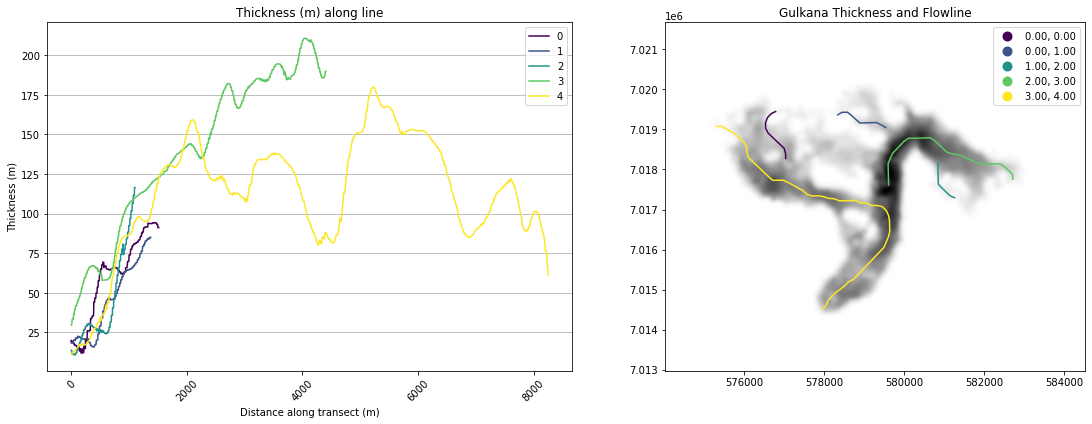

In [46]:
# plot the results
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

cm_subsection = np.linspace(0, 1, len(dist)) 
colors = [cm.viridis(x) for x in cm_subsection]
for i, c in enumerate(colors):
    ax1.plot(dist[i], vals[i], color=c)
ax1.grid(axis='y')
ax1.set_xlabel('Distance along transect (m)')
ax1.set_ylabel(cbar_title)
ax1.set_title(cbar_title + ' along line', c='k')
ax1.legend(ids)
plt.setp(ax1.get_xticklabels(), rotation=45);

main_flowline.plot(ax=ax2, column='SEGMENT_ID', cmap='viridis', legend=True, scheme='natural_breaks')
show((rasterio.open(tiff_name), 1), ax=ax2, cmap='Greys')
ax2.set_title('Gulkana Thickness and Flowline', c='k')
plt.tight_layout()

In [ ]:
# Google EarthEngine / EarthExplorer module/environment in Python?
